# CNN model (from "Fast Solar Image Classification Using Deep Learning and its Importance for Automation in Solar Physics" - Convolutional neural network)

## 0. Load modules


In [1]:
# Main libraries used all the time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Operating system libraries
import os
import sys

# Machine learning libraries
import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

import torch.nn as nn
import torch.optim as optim
import argparse
from tqdm import tqdm


from torchvision.transforms import v2 # library to define the transforms

#!pip install torcheval  # needs to run on google colab, on local machine you can just "pip install torcheval" in the terminal
from torcheval.metrics.functional import multiclass_f1_score

# Visualization and debugging
from sklearn.metrics import confusion_matrix
import seaborn as sns
#!pip install sunpy
from sunpy.visualization.colormaps import color_tables as ct


## 1. Import the data, create the dataset, define the Dataloaders

### 1.1 Declare data path

In [2]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # Carlos
    #folder0_path = '/content/drive/My Drive/solar_jets/data0'
    #folder0_test_path = '/content/drive/My Drive/solar_jets/data0_test'
    #folder1_path = '/content/drive/My Drive/solar_jets/data1'
    #folder1_test_path = '/content/drive/My Drive/solar_jets/data1_test'

    # Julie
    #folder0_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0'
    #folder1_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1'

    #folder0_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0_val'
    #folder1_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_val'


    #Adrien
    folder0_path = '/content/drive/My Drive/Machine Learning/Projet/data0'
    folder1_path = '/content/drive/My Drive/Machine Learning/Projet/data1'
    folder0_test_path = '/content/drive/My Drive/Machine Learning/Projet/data0_test'
    folder1_test_path = '/content/drive/My Drive/Machine Learning/Projet/data1_test'
    folder0_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data0_val'
    folder1_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data1_val'
else:
    # For local environments like VS Code
    folder0_path = './data0'
    folder1_path = './data1'
    folder0_test_path = './data0_test'
    folder1_test_path = './data1_test'
    folder0_valid_path = './data0_val'
    folder1_valid_path = './data1_val'

### 1.2 Declare the class and the transforms

In [3]:
class NPZDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir

        # in self.files, only add f if it has 30 samples
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = transform

    # Check if the file has 30 samples, if not, don't include it in self.files (see above)
    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']

        # Rearrange dimensions to (30, 166, 166) for PyTorch (insted of (166, 166, 30))
        data = np.moveaxis(data, -1, 0)

        # assign label 1 if data is from data1, 0 if from data0
        label = 1.0 if 'data1' in self.data_dir else 0.0
        return torch.from_numpy(data).float(), label

In [4]:
mean = 51.6644
std = 62.7087

train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()

    #v2.RandomResizedCrop(size=(55, 55)),                                          # weird pixelized img, we don't see the jet well sometimes
    #v2.RandomAffine(degrees=(-90,90), translate=(0.3, 0.3), scale=(0.8, 1.2)),    # good+useful if future sequences are not well cut out, moves the jet around the img
    #v2.RandomHorizontalFlip(p=0.4),                                               # just flips the image, no big difference
    #v2.RandomVerticalFlip(p=0.4),                                                 # same
    #v2.RandomRotation(degrees=(-90,90)),                                          # rotation, jet stays at the center of the image
    #v2.RandomZoomOut(side_range=(1,3), p=0.4),                                    # makes the jet smaller and not necessarely centered

    v2.Normalize((mean,), (std,)),
    # add other transforms if needed
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()
    v2.Normalize((mean,), (std,)),
])

### 1.3 Get the data, declare the Dataloaders

In [5]:
train_data1 = NPZDataset(folder1_path, transform=train_transform)
train_data0 = NPZDataset(folder0_path, transform=train_transform)
train_data = torch.utils.data.ConcatDataset([train_data1, train_data0])

test_data1 = NPZDataset(folder1_test_path, transform=test_transform)
test_data0 = NPZDataset(folder0_test_path, transform=test_transform)
test_data = torch.utils.data.ConcatDataset([test_data1, test_data0])

valid_data1 = NPZDataset(folder1_valid_path, transform=test_transform) #We can keep the same transforms as the test one
valid_data0 = NPZDataset(folder0_valid_path, transform=test_transform)
valid_data = torch.utils.data.ConcatDataset([valid_data1, valid_data0])

Visualize transforms: shows 5 images (10-15 of a sequence) of a chosen sequence in the data. The transform shown is the train_transform defined 2 cells above

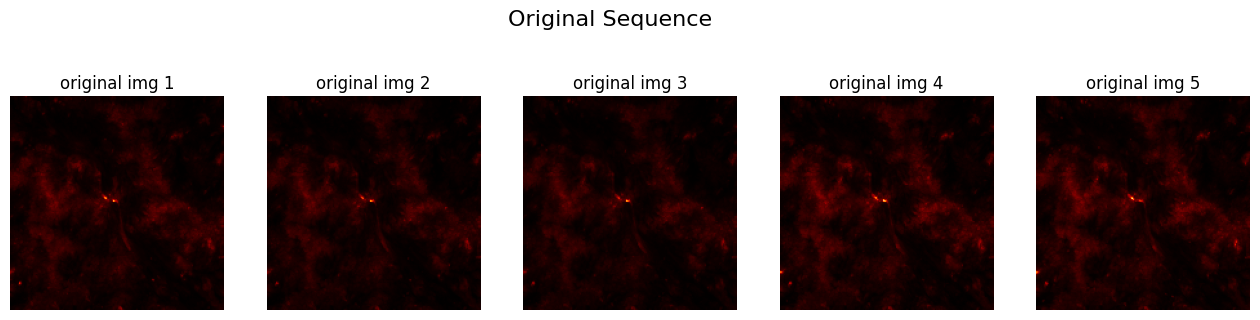

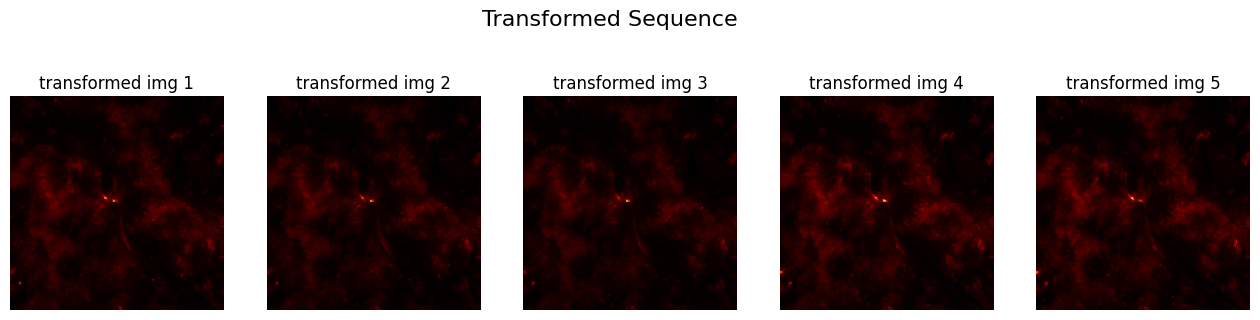

In [8]:
idx = 33 # index of image to visualize
sample_sequence, _ = train_data[idx]
original_sequence = np.moveaxis(sample_sequence.numpy(), 0, -1)  # Move axes back for visualization

# Display the original sequence

plt.figure(figsize=(16, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(original_sequence[:, :, 10+i], cmap='sdoaia304')
    plt.title(f'original img {i + 1}')
    plt.axis('off')

plt.suptitle('Original Sequence', fontsize=16)

# Plot the transformed sequence

plt.figure(figsize=(16, 4))
i = 0

for image in sample_sequence[10:15]:
    plt.subplot(1, 5, i + 1)
    trans = train_transform(image)
    plt.imshow(trans.squeeze(), cmap='sdoaia304')
    plt.title(f'transformed img {i + 1}')
    plt.axis('off')
    i += 1

plt.suptitle('Transformed Sequence', fontsize=16)
plt.show()

## 2. Define the CNN

In [9]:
import torch
import torch.nn as nn
from torch.nn.init import kaiming_normal_

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Linear(12800,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,2)
        )

        for m in self.modules():
            if not CNN:
                kaiming_normal_(m.weight,nonlinearity="relu")#Kaiming to initialize the weights

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

## 3. Define the training and validation functions

In [10]:
def train_epoch(model,device,data_loader,optimizer,epoch,criterion,scheduler):
    metrics="yes"
    model.train()

    for i, (images, labels) in tqdm(enumerate(data_loader),desc="Epoch no."+str(epoch)): #here the images are the pytorch tensor and labels are long 1 or 0
        images, labels = images.to(device), labels.long().to(device) #Give data and label to device (model already done above)
        optimizer.zero_grad() #must zero the gradients in the optimiser since backward() accumulates gradients and this stops mixing of values between batches
        output = model(images) #feeds the data through the network
        loss = criterion(output,labels) #finds the distance in the loss space between predicted values and actual values
        loss.backward() #backpropagation of the loss
        optimizer.step()
        scheduler.step()

        #Metrics
        if metrics=="yes":
          loss_history_train.append(loss.item())
          lr_history_train.append(scheduler.get_last_lr()[0])

          pred = output.argmax(dim=1, keepdim=True)
          correct = pred.eq(labels.view_as(pred)).sum().item()
          accuracy_float = correct / len(images)
          acc_history_train.append(accuracy_float)

In [16]:
def validate(model,device,data_loader,epoch,criterion):
    model.eval()
    total, correct = 0, 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.long().to(device)
            output = model(images)
            _, predicted = torch.max(output.data,1) #gives the max output index (that is our label)

            #Metrics
            total += labels.size(0)
            correct += (predicted == labels).sum()

            test_loss += criterion(output, labels).item() * len(images)
    print("Test Accuracy of the model on the test images: %f %% on epoch %d" % (100 * correct / total, epoch))

    #Metrics
    acc_history_test.append((correct / total).cpu().detach().numpy())

    test_loss /= len(data_loader.dataset)
    loss_history_test.append(test_loss)

In [17]:
#Model
model = CNN() #creates an instance of the CNN

#Hyperparameters
num_epochs=1   #by performing cross validation on bach and lr parameters : batch_size=2 and lr=1e-4 (Note : Learning rate can go even lower) , if we want to increase batch size we need to increase learning rate probably
batch_size=2

#Loading in consequence

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

#Other Hyperparameters

criterion = nn.CrossEntropyLoss()


"""
optimizer_kwargs = dict(
    lr=1e-4,
    weight_decay=1e-3,
)

optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
"""

optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9,nesterov=True)#Seems better optimizer than Adam for less epochs, we can increase lr as we are using scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR( #I think we don't need it for our model but still working, designed to adapt the learning rate during epochs
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )


#Parameters and Metrics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_history_train=[]
lr_history_train=[]
acc_history_train=[]

acc_history_test=[]
loss_history_test=[]


model.to(device)


for i in tqdm(range(1,num_epochs+1)):
  train_epoch(model,device,train_loader,optimizer,i,criterion, scheduler)
  validate(model,device,valid_loader,i, criterion)
  print(acc_history_test,loss_history_test)

cuda


  0%|          | 0/1 [00:00<?, ?it/s]
Epoch no.1: 0it [00:00, ?it/s]
Epoch no.1: 1it [00:00,  7.42it/s]
Epoch no.1: 2it [00:00,  7.81it/s]
Epoch no.1: 3it [00:00,  7.94it/s]
Epoch no.1: 4it [00:00,  8.03it/s]
Epoch no.1: 5it [00:00,  8.17it/s]
Epoch no.1: 6it [00:00,  8.31it/s]
Epoch no.1: 7it [00:00,  8.46it/s]
Epoch no.1: 8it [00:00,  8.72it/s]
Epoch no.1: 9it [00:01,  8.74it/s]
Epoch no.1: 10it [00:01,  8.86it/s]
Epoch no.1: 11it [00:01,  8.90it/s]
Epoch no.1: 12it [00:01,  8.86it/s]
Epoch no.1: 13it [00:01,  8.98it/s]
Epoch no.1: 14it [00:01,  9.17it/s]
Epoch no.1: 15it [00:01,  9.14it/s]
Epoch no.1: 16it [00:01,  9.25it/s]
Epoch no.1: 18it [00:02,  9.48it/s]
Epoch no.1: 19it [00:02,  9.48it/s]
Epoch no.1: 20it [00:02,  9.26it/s]
Epoch no.1: 21it [00:02,  9.22it/s]
Epoch no.1: 22it [00:02,  9.19it/s]
Epoch no.1: 23it [00:02,  9.26it/s]
Epoch no.1: 24it [00:02,  9.20it/s]
Epoch no.1: 25it [00:02,  8.98it/s]
Epoch no.1: 26it [00:02,  8.89it/s]
Epoch no.1: 27it [00:03,  8.82it/s]
Epoc

Test Accuracy of the model on the test images: 58.730164 % on epoch 1
[array(0.5873016, dtype=float32)] [0.7063659356226997]


## Final accuracy with test data

In [18]:
def test(model,device,data_loader,criterion):
    model.eval()
    total, correct = 0, 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.long().to(device)
            output = model(images)
            _, predicted = torch.max(output.data,1) #gives the max output index (that is our label)

            #Metrics
            total += labels.size(0)
            correct += (predicted == labels).sum()

            test_loss += criterion(output, labels).item() * len(images)
    print("Test Accuracy of the model on the test images: %f %%" % (100 * correct / total))


In [19]:
test(model, device, test_loader, criterion)

Test Accuracy of the model on the test images: 59.615383 %


## 6. Analyze the results

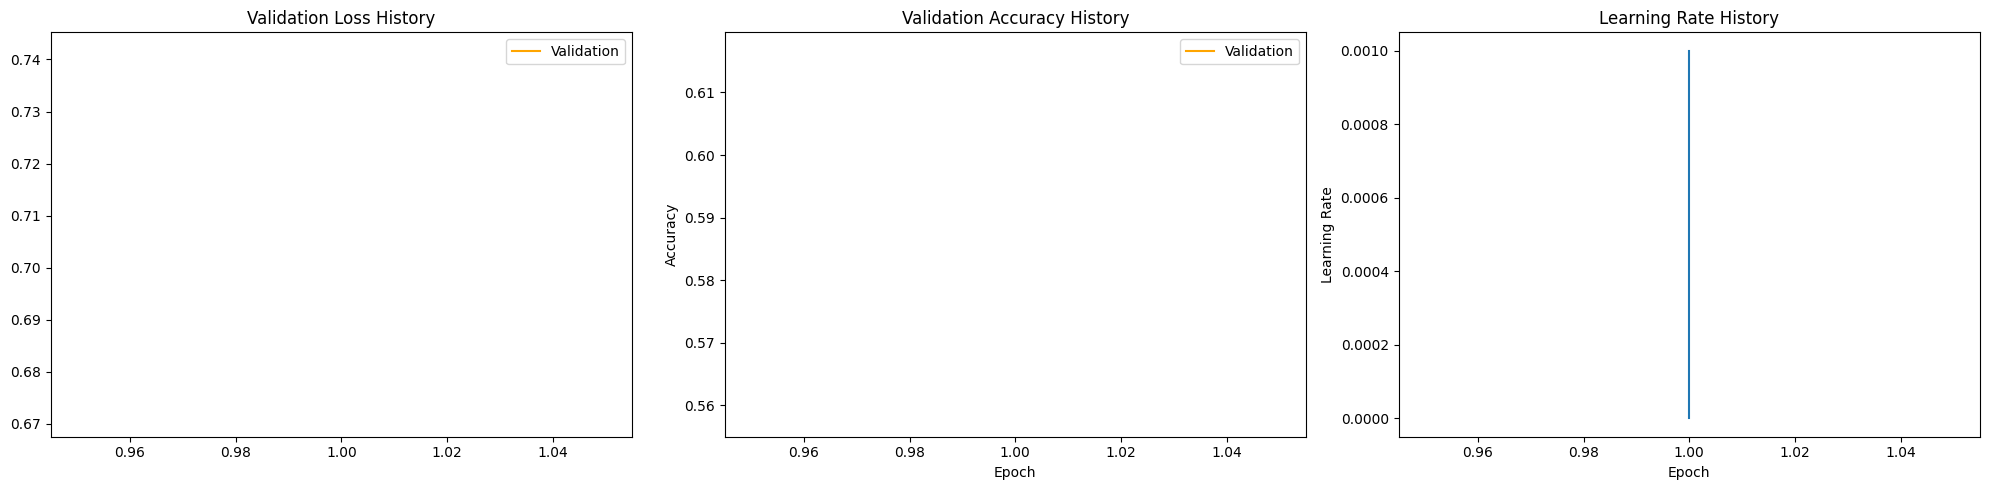

In [20]:
accuracy_history=acc_history_test.copy()
loss_history=loss_history_test
"""
for i in range(len(loss_history)):
  loss_history[i]=loss_history[i].cpu().detach().numpy()"""

#for i in range(len(accuracy_history)):                           #You might need to run this if the vector is stored on cuda
#  accuracy_history[i]=accuracy_history[i].cpu().detach().numpy()

n_train = len(accuracy_history)

t_test = np.arange(1, num_epochs + 1)
t_train = np.linspace(1,num_epochs,len(loss_history_train))

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plotting training accuracy history
#axs[0].plot(t_train, loss_history_train, label="Train")#train accuracy doesn't make so much sense as it is a batch of 2 datapoints (easy to go from 0 to 1)
axs[0].plot(t_test, loss_history, color='orange', label="Validation")
axs[0].legend()
axs[0].set_title('Validation Loss History')

#axs[1].plot(t_train, acc_history_train, label="Train")
axs[1].plot(t_test, accuracy_history, label="Validation", color='orange')
axs[1].set_title('Validation Accuracy History')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

axs[2].plot(t_train, lr_history_train)
axs[2].set_title('Learning Rate History')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')



plt.tight_layout()
plt.show()


## 7. Debugging tools

### a) Confusion matrix

predictions:  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

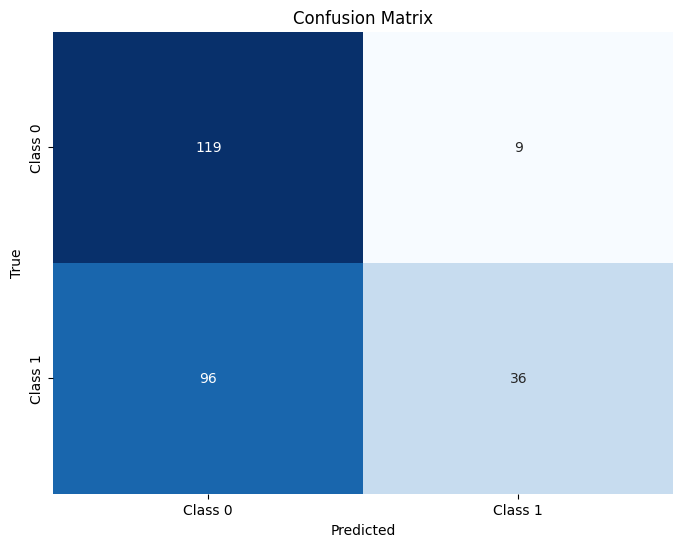

In [21]:
# Convert PyTorch tensors to NumPy arrays
model.eval()
predictions = []
labels = []
model = model.to(device)

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)
  pred = pred.cpu().numpy()
  target = target.cpu().numpy()
  target = np.array([t.item() for t in target], dtype=float)
  target = np.array(target, dtype=float)
  predictions.extend(pred)
  labels.extend(target)

print("predictions: ", predictions)
print("labels: ", labels)


# Compute confusion matrix using scikit-learn
cm = confusion_matrix(labels, predictions)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### b) Visualize misclassified images

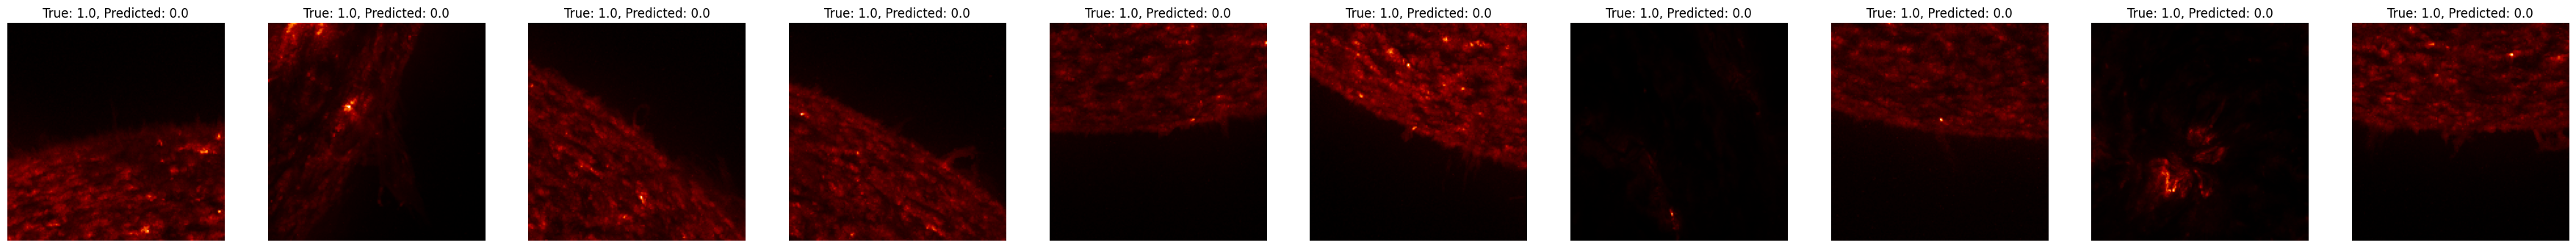

In [ ]:
# Set the model to evaluation mode
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

misclassified_images = []
true_labels = []
predicted_labels = []

# Iterate through the test set
for data, target in test_loader:
    # Forward pass
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)

    # Identify misclassified images
    misclassified_mask = pred != target
    misclassified_images.extend(data[misclassified_mask])
    true_labels.extend(target[misclassified_mask])
    predicted_labels.extend(pred[misclassified_mask])

# Convert lists to PyTorch tensors
misclassified_images = torch.stack(misclassified_images)
true_labels = torch.stack(true_labels)
predicted_labels = torch.stack(predicted_labels)

# Assuming you have a function to reverse normalization if applied during data preprocessing
# Replace reverse_normalize with your actual function
# Example:
reverse_normalize = transforms.Compose([transforms.Normalize(mean=0, std=(1/62.7087)),
                                        transforms.Normalize(mean=-51.6644, std=1)])

# Display misclassified images
num_images_to_display = min(10, len(misclassified_images))
fig, axes = plt.subplots(1, num_images_to_display, figsize=(45,6))

for i in range(num_images_to_display):
    # Assuming images are in RGB format
    image = reverse_normalize(misclassified_images[i]).cpu().numpy()
    true_label = true_labels[i].item()
    predicted_label = predicted_labels[i].item()

    axes[i].imshow(image[15,:,:], cmap='sdoaia304')
    axes[i].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[i].axis('off')

plt.show()
